<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[09:15:31] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


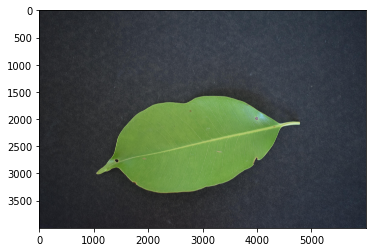

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

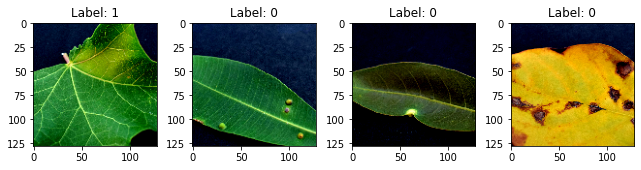

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[09:15:37] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[09:15:39] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2503668438313633 samples/sec                   batch loss = 0.4074503481388092 | accuracy = 0.7


Epoch[1] Batch[10] Speed: 1.198301786030211 samples/sec                   batch loss = 0.7064259052276611 | accuracy = 0.65


Epoch[1] Batch[15] Speed: 1.2644323900644945 samples/sec                   batch loss = 1.4303330183029175 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2622265383455904 samples/sec                   batch loss = 0.7032127976417542 | accuracy = 0.6625


Epoch[1] Batch[25] Speed: 1.2533986523653906 samples/sec                   batch loss = 1.208030343055725 | accuracy = 0.63


Epoch[1] Batch[30] Speed: 1.252895449136363 samples/sec                   batch loss = 0.6891208291053772 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.2519009031374575 samples/sec                   batch loss = 1.0702078342437744 | accuracy = 0.6142857142857143


Epoch[1] Batch[40] Speed: 1.2503674961402098 samples/sec                   batch loss = 0.4018687903881073 | accuracy = 0.60625


Epoch[1] Batch[45] Speed: 1.2540504403284634 samples/sec                   batch loss = 0.6702972650527954 | accuracy = 0.6166666666666667


Epoch[1] Batch[50] Speed: 1.253720760965899 samples/sec                   batch loss = 0.47043484449386597 | accuracy = 0.635


Epoch[1] Batch[55] Speed: 1.261798684894335 samples/sec                   batch loss = 0.5354071855545044 | accuracy = 0.6272727272727273


Epoch[1] Batch[60] Speed: 1.258178561564276 samples/sec                   batch loss = 0.5631952881813049 | accuracy = 0.625


Epoch[1] Batch[65] Speed: 1.2580427994492487 samples/sec                   batch loss = 0.796457052230835 | accuracy = 0.6346153846153846


Epoch[1] Batch[70] Speed: 1.2628269904134923 samples/sec                   batch loss = 0.9949232935905457 | accuracy = 0.6285714285714286


Epoch[1] Batch[75] Speed: 1.2599441522319168 samples/sec                   batch loss = 0.4124571681022644 | accuracy = 0.6333333333333333


Epoch[1] Batch[80] Speed: 1.2579095188042568 samples/sec                   batch loss = 0.35394904017448425 | accuracy = 0.64375


Epoch[1] Batch[85] Speed: 1.2559036330008928 samples/sec                   batch loss = 0.5957711935043335 | accuracy = 0.6323529411764706


Epoch[1] Batch[90] Speed: 1.258717559105208 samples/sec                   batch loss = 0.6039504408836365 | accuracy = 0.6388888888888888


Epoch[1] Batch[95] Speed: 1.259267982692475 samples/sec                   batch loss = 0.41977834701538086 | accuracy = 0.6447368421052632


Epoch[1] Batch[100] Speed: 1.2557852804728165 samples/sec                   batch loss = 0.8084302544593811 | accuracy = 0.635


Epoch[1] Batch[105] Speed: 1.2604964069515516 samples/sec                   batch loss = 0.44782543182373047 | accuracy = 0.6357142857142857


Epoch[1] Batch[110] Speed: 1.2613066373104842 samples/sec                   batch loss = 0.7357006072998047 | accuracy = 0.6386363636363637


Epoch[1] Batch[115] Speed: 1.2569829007723037 samples/sec                   batch loss = 0.34629347920417786 | accuracy = 0.6413043478260869


Epoch[1] Batch[120] Speed: 1.2643701653178316 samples/sec                   batch loss = 0.5898246169090271 | accuracy = 0.6479166666666667


Epoch[1] Batch[125] Speed: 1.260145441009173 samples/sec                   batch loss = 0.31539270281791687 | accuracy = 0.656


Epoch[1] Batch[130] Speed: 1.2602871482638842 samples/sec                   batch loss = 0.255150705575943 | accuracy = 0.6557692307692308


Epoch[1] Batch[135] Speed: 1.2542895147321984 samples/sec                   batch loss = 0.48680421710014343 | accuracy = 0.6592592592592592


Epoch[1] Batch[140] Speed: 1.2628679597730135 samples/sec                   batch loss = 0.3095828592777252 | accuracy = 0.6607142857142857


Epoch[1] Batch[145] Speed: 1.2611090535970837 samples/sec                   batch loss = 0.4819490909576416 | accuracy = 0.6637931034482759


Epoch[1] Batch[150] Speed: 1.2624783356480103 samples/sec                   batch loss = 0.6106778383255005 | accuracy = 0.6633333333333333


Epoch[1] Batch[155] Speed: 1.2639280029109823 samples/sec                   batch loss = 0.3913992643356323 | accuracy = 0.6629032258064517


Epoch[1] Batch[160] Speed: 1.267729796964092 samples/sec                   batch loss = 0.46974220871925354 | accuracy = 0.6609375


Epoch[1] Batch[165] Speed: 1.2591932230653429 samples/sec                   batch loss = 0.488897442817688 | accuracy = 0.6621212121212121


Epoch[1] Batch[170] Speed: 1.258526922092508 samples/sec                   batch loss = 0.4615212678909302 | accuracy = 0.6588235294117647


Epoch[1] Batch[175] Speed: 1.2694228002711476 samples/sec                   batch loss = 0.6613968014717102 | accuracy = 0.6628571428571428


Epoch[1] Batch[180] Speed: 1.2669257423581808 samples/sec                   batch loss = 0.8194860816001892 | accuracy = 0.6652777777777777


Epoch[1] Batch[185] Speed: 1.26261049581038 samples/sec                   batch loss = 0.24008752405643463 | accuracy = 0.6716216216216216


Epoch[1] Batch[190] Speed: 1.2590014026912582 samples/sec                   batch loss = 0.4524364471435547 | accuracy = 0.6697368421052632


Epoch[1] Batch[195] Speed: 1.2619348792218934 samples/sec                   batch loss = 0.34139010310173035 | accuracy = 0.6692307692307692


Epoch[1] Batch[200] Speed: 1.2595117928784785 samples/sec                   batch loss = 0.3122033476829529 | accuracy = 0.6675


Epoch[1] Batch[205] Speed: 1.2644150465638944 samples/sec                   batch loss = 0.7765779495239258 | accuracy = 0.6670731707317074


Epoch[1] Batch[210] Speed: 1.2673791960007628 samples/sec                   batch loss = 1.0955274105072021 | accuracy = 0.6666666666666666


Epoch[1] Batch[215] Speed: 1.2602846868104796 samples/sec                   batch loss = 0.6625069379806519 | accuracy = 0.6674418604651163


Epoch[1] Batch[220] Speed: 1.2621260754207102 samples/sec                   batch loss = 0.5269399285316467 | accuracy = 0.6681818181818182


Epoch[1] Batch[225] Speed: 1.2591116686410782 samples/sec                   batch loss = 0.4263457655906677 | accuracy = 0.6688888888888889


Epoch[1] Batch[230] Speed: 1.2653816712914563 samples/sec                   batch loss = 0.37374264001846313 | accuracy = 0.6706521739130434


Epoch[1] Batch[235] Speed: 1.2598738535348104 samples/sec                   batch loss = 1.27290678024292 | accuracy = 0.6691489361702128


Epoch[1] Batch[240] Speed: 1.2633515229413534 samples/sec                   batch loss = 0.9085284471511841 | accuracy = 0.66875


Epoch[1] Batch[245] Speed: 1.2667478184236234 samples/sec                   batch loss = 0.8141745328903198 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.2647133829407384 samples/sec                   batch loss = 0.49705150723457336 | accuracy = 0.668


Epoch[1] Batch[255] Speed: 1.2602777758580852 samples/sec                   batch loss = 0.5949207544326782 | accuracy = 0.6637254901960784


Epoch[1] Batch[260] Speed: 1.25687696204231 samples/sec                   batch loss = 0.28072577714920044 | accuracy = 0.6653846153846154


Epoch[1] Batch[265] Speed: 1.260333065599578 samples/sec                   batch loss = 0.48221248388290405 | accuracy = 0.6669811320754717


Epoch[1] Batch[270] Speed: 1.2634911927656665 samples/sec                   batch loss = 0.6264248490333557 | accuracy = 0.6685185185185185


Epoch[1] Batch[275] Speed: 1.2581966779745672 samples/sec                   batch loss = 0.2962424159049988 | accuracy = 0.67


Epoch[1] Batch[280] Speed: 1.259612880304982 samples/sec                   batch loss = 0.5540962219238281 | accuracy = 0.6705357142857142


Epoch[1] Batch[285] Speed: 1.262967685170457 samples/sec                   batch loss = 0.25834164023399353 | accuracy = 0.6684210526315789


Epoch[1] Batch[290] Speed: 1.2645860246990965 samples/sec                   batch loss = 0.6356807947158813 | accuracy = 0.6655172413793103


Epoch[1] Batch[295] Speed: 1.2627308036643334 samples/sec                   batch loss = 1.2650686502456665 | accuracy = 0.6661016949152543


Epoch[1] Batch[300] Speed: 1.2829380761896503 samples/sec                   batch loss = 0.3539000451564789 | accuracy = 0.6666666666666666


Epoch[1] Batch[305] Speed: 1.2912627882589496 samples/sec                   batch loss = 0.5279550552368164 | accuracy = 0.6672131147540984


Epoch[1] Batch[310] Speed: 1.2884942789962393 samples/sec                   batch loss = 0.33864980936050415 | accuracy = 0.6701612903225806


Epoch[1] Batch[315] Speed: 1.2835477945747107 samples/sec                   batch loss = 0.7981910705566406 | accuracy = 0.6698412698412698


Epoch[1] Batch[320] Speed: 1.2817142066988703 samples/sec                   batch loss = 0.24770358204841614 | accuracy = 0.67265625


Epoch[1] Batch[325] Speed: 1.287603394710326 samples/sec                   batch loss = 0.8410032987594604 | accuracy = 0.6723076923076923


Epoch[1] Batch[330] Speed: 1.2866242419218148 samples/sec                   batch loss = 0.6165033578872681 | accuracy = 0.6734848484848485


Epoch[1] Batch[335] Speed: 1.2863893523879364 samples/sec                   batch loss = 0.4041796028614044 | accuracy = 0.673134328358209


Epoch[1] Batch[340] Speed: 1.2894227653623556 samples/sec                   batch loss = 0.8002333045005798 | accuracy = 0.674264705882353


Epoch[1] Batch[345] Speed: 1.2909962997353635 samples/sec                   batch loss = 0.5049055814743042 | accuracy = 0.6739130434782609


Epoch[1] Batch[350] Speed: 1.2903455446580943 samples/sec                   batch loss = 0.4130035936832428 | accuracy = 0.6742857142857143


Epoch[1] Batch[355] Speed: 1.287037603153658 samples/sec                   batch loss = 0.35439568758010864 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.2857332804138448 samples/sec                   batch loss = 0.28594815731048584 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.290263874291756 samples/sec                   batch loss = 1.1041221618652344 | accuracy = 0.6732876712328767


Epoch[1] Batch[370] Speed: 1.2913971672143443 samples/sec                   batch loss = 0.21465058624744415 | accuracy = 0.6756756756756757


Epoch[1] Batch[375] Speed: 1.2807145588355076 samples/sec                   batch loss = 0.5786716341972351 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.2849315246848505 samples/sec                   batch loss = 0.3267071843147278 | accuracy = 0.6796052631578947


Epoch[1] Batch[385] Speed: 1.2864130248926189 samples/sec                   batch loss = 0.4520340859889984 | accuracy = 0.6798701298701298


Epoch[1] Batch[390] Speed: 1.2813004409611592 samples/sec                   batch loss = 1.2343682050704956 | accuracy = 0.6814102564102564


Epoch[1] Batch[395] Speed: 1.2779791720337241 samples/sec                   batch loss = 1.0443249940872192 | accuracy = 0.6822784810126582


Epoch[1] Batch[400] Speed: 1.2782527788706781 samples/sec                   batch loss = 0.2687774896621704 | accuracy = 0.684375


Epoch[1] Batch[405] Speed: 1.283825264884552 samples/sec                   batch loss = 1.0397460460662842 | accuracy = 0.6833333333333333


Epoch[1] Batch[410] Speed: 1.274934966007238 samples/sec                   batch loss = 0.5469484329223633 | accuracy = 0.6835365853658537


Epoch[1] Batch[415] Speed: 1.2828368397369212 samples/sec                   batch loss = 0.40929171442985535 | accuracy = 0.6831325301204819


Epoch[1] Batch[420] Speed: 1.2862696223167858 samples/sec                   batch loss = 0.4944635033607483 | accuracy = 0.6839285714285714


Epoch[1] Batch[425] Speed: 1.2852826497579775 samples/sec                   batch loss = 0.5145832300186157 | accuracy = 0.6852941176470588


Epoch[1] Batch[430] Speed: 1.283449407369492 samples/sec                   batch loss = 0.8441152572631836 | accuracy = 0.6843023255813954


Epoch[1] Batch[435] Speed: 1.2835882535704861 samples/sec                   batch loss = 0.42460134625434875 | accuracy = 0.6844827586206896


Epoch[1] Batch[440] Speed: 1.2829617199495111 samples/sec                   batch loss = 0.2958148419857025 | accuracy = 0.6852272727272727


Epoch[1] Batch[445] Speed: 1.2866100336498987 samples/sec                   batch loss = 1.1449449062347412 | accuracy = 0.6859550561797753


Epoch[1] Batch[450] Speed: 1.2776017674342384 samples/sec                   batch loss = 0.7309513688087463 | accuracy = 0.6877777777777778


Epoch[1] Batch[455] Speed: 1.2824180358381427 samples/sec                   batch loss = 1.3750563859939575 | accuracy = 0.6873626373626374


Epoch[1] Batch[460] Speed: 1.2870643603678578 samples/sec                   batch loss = 0.8027562499046326 | accuracy = 0.6880434782608695


Epoch[1] Batch[465] Speed: 1.2838871595795254 samples/sec                   batch loss = 0.4112308919429779 | accuracy = 0.6887096774193548


Epoch[1] Batch[470] Speed: 1.2832235273637373 samples/sec                   batch loss = 0.3507392108440399 | accuracy = 0.6893617021276596


Epoch[1] Batch[475] Speed: 1.2798409377374593 samples/sec                   batch loss = 0.5954365134239197 | accuracy = 0.69


Epoch[1] Batch[480] Speed: 1.2833346413585962 samples/sec                   batch loss = 0.9619477987289429 | accuracy = 0.6911458333333333


Epoch[1] Batch[485] Speed: 1.2829985117653586 samples/sec                   batch loss = 0.6214784383773804 | accuracy = 0.6902061855670103


Epoch[1] Batch[490] Speed: 1.2822003580210088 samples/sec                   batch loss = 0.7461538910865784 | accuracy = 0.6872448979591836


Epoch[1] Batch[495] Speed: 1.2878437695285978 samples/sec                   batch loss = 1.0564968585968018 | accuracy = 0.6868686868686869


Epoch[1] Batch[500] Speed: 1.28819183944777 samples/sec                   batch loss = 0.4085659682750702 | accuracy = 0.6865


Epoch[1] Batch[505] Speed: 1.285005041303147 samples/sec                   batch loss = 0.6324755549430847 | accuracy = 0.6841584158415842


Epoch[1] Batch[510] Speed: 1.286996334059965 samples/sec                   batch loss = 0.5456443428993225 | accuracy = 0.682843137254902


Epoch[1] Batch[515] Speed: 1.2823544204045896 samples/sec                   batch loss = 0.5081802606582642 | accuracy = 0.6839805825242719


Epoch[1] Batch[520] Speed: 1.2825507761866481 samples/sec                   batch loss = 0.9988800287246704 | accuracy = 0.6846153846153846


Epoch[1] Batch[525] Speed: 1.2796792795994962 samples/sec                   batch loss = 0.4921267032623291 | accuracy = 0.6833333333333333


Epoch[1] Batch[530] Speed: 1.2852229833550561 samples/sec                   batch loss = 0.9900848865509033 | accuracy = 0.6834905660377358


Epoch[1] Batch[535] Speed: 1.2804634489900215 samples/sec                   batch loss = 0.6224218010902405 | accuracy = 0.6841121495327103


Epoch[1] Batch[540] Speed: 1.2812890899069673 samples/sec                   batch loss = 0.29048842191696167 | accuracy = 0.6842592592592592


Epoch[1] Batch[545] Speed: 1.2853605394874574 samples/sec                   batch loss = 0.7806866765022278 | accuracy = 0.6839449541284404


Epoch[1] Batch[550] Speed: 1.2843209828722153 samples/sec                   batch loss = 0.3820074200630188 | accuracy = 0.6863636363636364


Epoch[1] Batch[555] Speed: 1.2786550280097069 samples/sec                   batch loss = 0.1747022420167923 | accuracy = 0.6882882882882883


Epoch[1] Batch[560] Speed: 1.288186893955489 samples/sec                   batch loss = 0.34611180424690247 | accuracy = 0.6883928571428571


Epoch[1] Batch[565] Speed: 1.2859535394808024 samples/sec                   batch loss = 0.36429768800735474 | accuracy = 0.6889380530973451


Epoch[1] Batch[570] Speed: 1.2809460111532565 samples/sec                   batch loss = 0.4042204022407532 | accuracy = 0.6881578947368421


Epoch[1] Batch[575] Speed: 1.2800179690022504 samples/sec                   batch loss = 0.8551486730575562 | accuracy = 0.6882608695652174


Epoch[1] Batch[580] Speed: 1.2764236920420415 samples/sec                   batch loss = 0.41135209798812866 | accuracy = 0.6883620689655172


Epoch[1] Batch[585] Speed: 1.2892388632159537 samples/sec                   batch loss = 0.4762181341648102 | accuracy = 0.688034188034188


Epoch[1] Batch[590] Speed: 1.2944314011111737 samples/sec                   batch loss = 0.6493049263954163 | accuracy = 0.6885593220338984


Epoch[1] Batch[595] Speed: 1.2876611081080314 samples/sec                   batch loss = 0.6278665661811829 | accuracy = 0.6907563025210084


Epoch[1] Batch[600] Speed: 1.2877728931172239 samples/sec                   batch loss = 0.5104436278343201 | accuracy = 0.6916666666666667


Epoch[1] Batch[605] Speed: 1.2867578544944638 samples/sec                   batch loss = 0.35079699754714966 | accuracy = 0.6925619834710743


Epoch[1] Batch[610] Speed: 1.2817838301732016 samples/sec                   batch loss = 0.3961959779262543 | accuracy = 0.6930327868852459


Epoch[1] Batch[615] Speed: 1.2827027652718566 samples/sec                   batch loss = 0.658420741558075 | accuracy = 0.6934959349593496


Epoch[1] Batch[620] Speed: 1.2792356129973605 samples/sec                   batch loss = 0.3477904200553894 | accuracy = 0.6915322580645161


Epoch[1] Batch[625] Speed: 1.2826397099438274 samples/sec                   batch loss = 0.5013140439987183 | accuracy = 0.6924


Epoch[1] Batch[630] Speed: 1.2871861148033703 samples/sec                   batch loss = 0.6634756922721863 | accuracy = 0.6936507936507936


Epoch[1] Batch[635] Speed: 1.2870402689516676 samples/sec                   batch loss = 0.49057483673095703 | accuracy = 0.694488188976378


Epoch[1] Batch[640] Speed: 1.285002777613743 samples/sec                   batch loss = 0.3894573152065277 | accuracy = 0.695703125


Epoch[1] Batch[645] Speed: 1.2842884408715534 samples/sec                   batch loss = 0.5405592918395996 | accuracy = 0.6968992248062016


Epoch[1] Batch[650] Speed: 1.2888621069739472 samples/sec                   batch loss = 0.295769602060318 | accuracy = 0.6976923076923077


Epoch[1] Batch[655] Speed: 1.29423288856688 samples/sec                   batch loss = 1.1195130348205566 | accuracy = 0.6977099236641221


Epoch[1] Batch[660] Speed: 1.2895454620221183 samples/sec                   batch loss = 0.4863319993019104 | accuracy = 0.6977272727272728


Epoch[1] Batch[665] Speed: 1.2843201963391566 samples/sec                   batch loss = 0.1775602102279663 | accuracy = 0.6992481203007519


Epoch[1] Batch[670] Speed: 1.2864327526454076 samples/sec                   batch loss = 0.3698892593383789 | accuracy = 0.6992537313432836


Epoch[1] Batch[675] Speed: 1.2833871621781332 samples/sec                   batch loss = 0.5337669253349304 | accuracy = 0.6992592592592592


Epoch[1] Batch[680] Speed: 1.2894162248389538 samples/sec                   batch loss = 0.32681769132614136 | accuracy = 0.6992647058823529


Epoch[1] Batch[685] Speed: 1.2848073430270444 samples/sec                   batch loss = 0.4017152190208435 | accuracy = 0.6996350364963504


Epoch[1] Batch[690] Speed: 1.2809143245254715 samples/sec                   batch loss = 0.4405291676521301 | accuracy = 0.6992753623188406


Epoch[1] Batch[695] Speed: 1.2814370608029741 samples/sec                   batch loss = 1.3618242740631104 | accuracy = 0.6992805755395683


Epoch[1] Batch[700] Speed: 1.2824692072230133 samples/sec                   batch loss = 0.49742186069488525 | accuracy = 0.6989285714285715


Epoch[1] Batch[705] Speed: 1.2834802376653185 samples/sec                   batch loss = 1.3655177354812622 | accuracy = 0.698936170212766


Epoch[1] Batch[710] Speed: 1.2843417280294231 samples/sec                   batch loss = 0.3770216107368469 | accuracy = 0.698943661971831


Epoch[1] Batch[715] Speed: 1.281315119346662 samples/sec                   batch loss = 0.6906905174255371 | accuracy = 0.6993006993006993


Epoch[1] Batch[720] Speed: 1.286397341760864 samples/sec                   batch loss = 0.7672516107559204 | accuracy = 0.6989583333333333


Epoch[1] Batch[725] Speed: 1.279254535969106 samples/sec                   batch loss = 0.12887410819530487 | accuracy = 0.6996551724137932


Epoch[1] Batch[730] Speed: 1.2808313012603625 samples/sec                   batch loss = 0.9136976003646851 | accuracy = 0.6989726027397261


Epoch[1] Batch[735] Speed: 1.283623117129618 samples/sec                   batch loss = 0.8772580623626709 | accuracy = 0.7


Epoch[1] Batch[740] Speed: 1.2814096562067294 samples/sec                   batch loss = 0.749485969543457 | accuracy = 0.7003378378378379


Epoch[1] Batch[745] Speed: 1.2787742218533809 samples/sec                   batch loss = 0.32574108242988586 | accuracy = 0.7013422818791947


Epoch[1] Batch[750] Speed: 1.2811408596888954 samples/sec                   batch loss = 0.4708252549171448 | accuracy = 0.701


Epoch[1] Batch[755] Speed: 1.2823580470007945 samples/sec                   batch loss = 0.19621625542640686 | accuracy = 0.7013245033112583


Epoch[1] Batch[760] Speed: 1.2833459305178518 samples/sec                   batch loss = 0.5181320905685425 | accuracy = 0.7023026315789473


Epoch[1] Batch[765] Speed: 1.2784556740808317 samples/sec                   batch loss = 0.42819520831108093 | accuracy = 0.7029411764705882


Epoch[1] Batch[770] Speed: 1.2611608137866699 samples/sec                   batch loss = 0.9468746781349182 | accuracy = 0.7025974025974026


Epoch[1] Batch[775] Speed: 1.2622385038050619 samples/sec                   batch loss = 0.44457101821899414 | accuracy = 0.702258064516129


Epoch[1] Batch[780] Speed: 1.2622924461531273 samples/sec                   batch loss = 0.6406185626983643 | accuracy = 0.7025641025641025


Epoch[1] Batch[785] Speed: 1.2635568520585048 samples/sec                   batch loss = 0.4678407609462738 | accuracy = 0.7035031847133758


[Epoch 1] training: accuracy=0.703997461928934
[Epoch 1] time cost: 647.1062462329865
[Epoch 1] validation: validation accuracy=0.7822222222222223


Epoch[2] Batch[5] Speed: 1.2589032472862494 samples/sec                   batch loss = 0.34848058223724365 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2693493270651268 samples/sec                   batch loss = 0.5570799112319946 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2581725228767797 samples/sec                   batch loss = 0.7795647978782654 | accuracy = 0.7333333333333333


Epoch[2] Batch[20] Speed: 1.2567500474168527 samples/sec                   batch loss = 0.16891120374202728 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2614505976305606 samples/sec                   batch loss = 0.3999049663543701 | accuracy = 0.73


Epoch[2] Batch[30] Speed: 1.2556550150785932 samples/sec                   batch loss = 0.4676923453807831 | accuracy = 0.7416666666666667


Epoch[2] Batch[35] Speed: 1.252592935532499 samples/sec                   batch loss = 0.8732802271842957 | accuracy = 0.7285714285714285


Epoch[2] Batch[40] Speed: 1.2579242320534043 samples/sec                   batch loss = 0.11213621497154236 | accuracy = 0.7


Epoch[2] Batch[45] Speed: 1.2514715249323978 samples/sec                   batch loss = 0.4946935474872589 | accuracy = 0.6888888888888889


Epoch[2] Batch[50] Speed: 1.2623990148342954 samples/sec                   batch loss = 0.2165987491607666 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.2597505895642453 samples/sec                   batch loss = 0.43071112036705017 | accuracy = 0.7045454545454546


Epoch[2] Batch[60] Speed: 1.2567668988475602 samples/sec                   batch loss = 0.4166676700115204 | accuracy = 0.7125


Epoch[2] Batch[65] Speed: 1.2648897821487801 samples/sec                   batch loss = 0.23350396752357483 | accuracy = 0.7269230769230769


Epoch[2] Batch[70] Speed: 1.2611706733521308 samples/sec                   batch loss = 0.7077382802963257 | accuracy = 0.7285714285714285


Epoch[2] Batch[75] Speed: 1.2667245772133702 samples/sec                   batch loss = 0.47549471259117126 | accuracy = 0.74


Epoch[2] Batch[80] Speed: 1.2667483922914555 samples/sec                   batch loss = 0.647240400314331 | accuracy = 0.74375


Epoch[2] Batch[85] Speed: 1.2587535401753065 samples/sec                   batch loss = 0.30377933382987976 | accuracy = 0.7352941176470589


Epoch[2] Batch[90] Speed: 1.2651094440934696 samples/sec                   batch loss = 1.11521577835083 | accuracy = 0.7333333333333333


Epoch[2] Batch[95] Speed: 1.2652604761230692 samples/sec                   batch loss = 0.42496269941329956 | accuracy = 0.7289473684210527


Epoch[2] Batch[100] Speed: 1.265832109982999 samples/sec                   batch loss = 0.5960543155670166 | accuracy = 0.7375


Epoch[2] Batch[105] Speed: 1.2598214421146645 samples/sec                   batch loss = 0.6843215823173523 | accuracy = 0.7380952380952381


Epoch[2] Batch[110] Speed: 1.2646481753669125 samples/sec                   batch loss = 0.42671072483062744 | accuracy = 0.7363636363636363


Epoch[2] Batch[115] Speed: 1.2519824603821343 samples/sec                   batch loss = 0.4168131649494171 | accuracy = 0.7391304347826086


Epoch[2] Batch[120] Speed: 1.2541148408157285 samples/sec                   batch loss = 0.16121669113636017 | accuracy = 0.74375


Epoch[2] Batch[125] Speed: 1.2560199391440459 samples/sec                   batch loss = 0.6065671443939209 | accuracy = 0.742


Epoch[2] Batch[130] Speed: 1.2602166219658706 samples/sec                   batch loss = 0.6052852272987366 | accuracy = 0.7442307692307693


Epoch[2] Batch[135] Speed: 1.2580442144695942 samples/sec                   batch loss = 0.09928129613399506 | accuracy = 0.7407407407407407


Epoch[2] Batch[140] Speed: 1.26098469483278 samples/sec                   batch loss = 0.335674524307251 | accuracy = 0.7464285714285714


Epoch[2] Batch[145] Speed: 1.263659351290216 samples/sec                   batch loss = 0.19394518435001373 | accuracy = 0.7482758620689656


Epoch[2] Batch[150] Speed: 1.2567119215459912 samples/sec                   batch loss = 0.5090426206588745 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.2522840248399434 samples/sec                   batch loss = 0.6256554126739502 | accuracy = 0.7403225806451613


Epoch[2] Batch[160] Speed: 1.2556170495886385 samples/sec                   batch loss = 0.17115090787410736 | accuracy = 0.7421875


Epoch[2] Batch[165] Speed: 1.2578994272233912 samples/sec                   batch loss = 0.4314006567001343 | accuracy = 0.7393939393939394


Epoch[2] Batch[170] Speed: 1.2563425498879963 samples/sec                   batch loss = 0.22746536135673523 | accuracy = 0.7397058823529412


Epoch[2] Batch[175] Speed: 1.2580124244467425 samples/sec                   batch loss = 0.428129106760025 | accuracy = 0.7385714285714285


Epoch[2] Batch[180] Speed: 1.262966544276092 samples/sec                   batch loss = 0.15792691707611084 | accuracy = 0.7361111111111112


Epoch[2] Batch[185] Speed: 1.2632889289138995 samples/sec                   batch loss = 0.7520654201507568 | accuracy = 0.7391891891891892


Epoch[2] Batch[190] Speed: 1.2582333841759972 samples/sec                   batch loss = 0.3084031641483307 | accuracy = 0.7368421052631579


Epoch[2] Batch[195] Speed: 1.2595288130116653 samples/sec                   batch loss = 1.2092978954315186 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.268164558579045 samples/sec                   batch loss = 1.5008033514022827 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.2626869922260364 samples/sec                   batch loss = 0.8670192956924438 | accuracy = 0.7341463414634146


Epoch[2] Batch[210] Speed: 1.2597136056177833 samples/sec                   batch loss = 0.4332271218299866 | accuracy = 0.7380952380952381


Epoch[2] Batch[215] Speed: 1.2593842510761153 samples/sec                   batch loss = 0.47548431158065796 | accuracy = 0.7383720930232558


Epoch[2] Batch[220] Speed: 1.2670250571237656 samples/sec                   batch loss = 0.4013831615447998 | accuracy = 0.7363636363636363


Epoch[2] Batch[225] Speed: 1.2638034683979378 samples/sec                   batch loss = 0.5760917067527771 | accuracy = 0.7377777777777778


Epoch[2] Batch[230] Speed: 1.265743390787601 samples/sec                   batch loss = 0.5255510807037354 | accuracy = 0.7336956521739131


Epoch[2] Batch[235] Speed: 1.2702397418880635 samples/sec                   batch loss = 0.3483981788158417 | accuracy = 0.7351063829787234


Epoch[2] Batch[240] Speed: 1.2671694644565317 samples/sec                   batch loss = 0.15212225914001465 | accuracy = 0.734375


Epoch[2] Batch[245] Speed: 1.263100518378753 samples/sec                   batch loss = 0.31603023409843445 | accuracy = 0.7316326530612245


Epoch[2] Batch[250] Speed: 1.265109825682975 samples/sec                   batch loss = 0.5040831565856934 | accuracy = 0.73


Epoch[2] Batch[255] Speed: 1.273187622502036 samples/sec                   batch loss = 0.6662724614143372 | accuracy = 0.7313725490196078


Epoch[2] Batch[260] Speed: 1.263726360704755 samples/sec                   batch loss = 0.32197141647338867 | accuracy = 0.7307692307692307


Epoch[2] Batch[265] Speed: 1.259420742978859 samples/sec                   batch loss = 0.36050763726234436 | accuracy = 0.7330188679245283


Epoch[2] Batch[270] Speed: 1.2648501118763877 samples/sec                   batch loss = 0.6428375244140625 | accuracy = 0.7314814814814815


Epoch[2] Batch[275] Speed: 1.2595491432180606 samples/sec                   batch loss = 1.3613547086715698 | accuracy = 0.7336363636363636


Epoch[2] Batch[280] Speed: 1.2638099420645101 samples/sec                   batch loss = 0.32652172446250916 | accuracy = 0.7366071428571429


Epoch[2] Batch[285] Speed: 1.2604153464730272 samples/sec                   batch loss = 0.3926261067390442 | accuracy = 0.7368421052631579


Epoch[2] Batch[290] Speed: 1.2598389436382331 samples/sec                   batch loss = 0.8264956474304199 | accuracy = 0.7353448275862069


Epoch[2] Batch[295] Speed: 1.2602624394947357 samples/sec                   batch loss = 0.4556550979614258 | accuracy = 0.738135593220339


Epoch[2] Batch[300] Speed: 1.2623871413187226 samples/sec                   batch loss = 0.4276890158653259 | accuracy = 0.7383333333333333


Epoch[2] Batch[305] Speed: 1.2611349331607842 samples/sec                   batch loss = 0.3198813796043396 | accuracy = 0.740983606557377


Epoch[2] Batch[310] Speed: 1.2612628298217723 samples/sec                   batch loss = 0.42054814100265503 | accuracy = 0.739516129032258


Epoch[2] Batch[315] Speed: 1.2645728708931967 samples/sec                   batch loss = 0.4711180329322815 | accuracy = 0.7420634920634921


Epoch[2] Batch[320] Speed: 1.2624914459159902 samples/sec                   batch loss = 0.2666615843772888 | accuracy = 0.74375


Epoch[2] Batch[325] Speed: 1.2638912493476093 samples/sec                   batch loss = 0.497059166431427 | accuracy = 0.7430769230769231


Epoch[2] Batch[330] Speed: 1.264032371831239 samples/sec                   batch loss = 0.3872799575328827 | accuracy = 0.7424242424242424


Epoch[2] Batch[335] Speed: 1.2648757637634231 samples/sec                   batch loss = 0.3132370710372925 | accuracy = 0.7432835820895523


Epoch[2] Batch[340] Speed: 1.2674736026353322 samples/sec                   batch loss = 1.2496954202651978 | accuracy = 0.7419117647058824


Epoch[2] Batch[345] Speed: 1.2705845181530997 samples/sec                   batch loss = 0.4679034352302551 | accuracy = 0.7434782608695653


Epoch[2] Batch[350] Speed: 1.2658578972271226 samples/sec                   batch loss = 0.5088931918144226 | accuracy = 0.7428571428571429


Epoch[2] Batch[355] Speed: 1.263630512777929 samples/sec                   batch loss = 0.40949583053588867 | accuracy = 0.7422535211267606


Epoch[2] Batch[360] Speed: 1.2568401466297123 samples/sec                   batch loss = 0.07116174697875977 | accuracy = 0.7451388888888889


Epoch[2] Batch[365] Speed: 1.261804094143197 samples/sec                   batch loss = 0.3261640965938568 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.2644350583375858 samples/sec                   batch loss = 0.9489497542381287 | accuracy = 0.745945945945946


Epoch[2] Batch[375] Speed: 1.2652431098984145 samples/sec                   batch loss = 0.13138790428638458 | accuracy = 0.7453333333333333


Epoch[2] Batch[380] Speed: 1.2620356914474167 samples/sec                   batch loss = 1.1608517169952393 | accuracy = 0.743421052631579


Epoch[2] Batch[385] Speed: 1.2685199102966773 samples/sec                   batch loss = 0.3193400800228119 | accuracy = 0.7441558441558441


Epoch[2] Batch[390] Speed: 1.2607105666128584 samples/sec                   batch loss = 0.4490085542201996 | accuracy = 0.7448717948717949


Epoch[2] Batch[395] Speed: 1.2579354558530846 samples/sec                   batch loss = 1.0222293138504028 | accuracy = 0.7436708860759493


Epoch[2] Batch[400] Speed: 1.257086125812643 samples/sec                   batch loss = 0.6158701181411743 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.2674736026353322 samples/sec                   batch loss = 0.9374626874923706 | accuracy = 0.7444444444444445


Epoch[2] Batch[410] Speed: 1.2623320511288687 samples/sec                   batch loss = 0.3554825484752655 | accuracy = 0.7439024390243902


Epoch[2] Batch[415] Speed: 1.26110156483724 samples/sec                   batch loss = 1.3946094512939453 | accuracy = 0.7415662650602409


Epoch[2] Batch[420] Speed: 1.2602610194799726 samples/sec                   batch loss = 0.42934519052505493 | accuracy = 0.7416666666666667


Epoch[2] Batch[425] Speed: 1.2592176063930234 samples/sec                   batch loss = 0.19678087532520294 | accuracy = 0.7435294117647059


Epoch[2] Batch[430] Speed: 1.2600297891030043 samples/sec                   batch loss = 0.3737928867340088 | accuracy = 0.7436046511627907


Epoch[2] Batch[435] Speed: 1.2567201113527924 samples/sec                   batch loss = 0.29175373911857605 | accuracy = 0.7436781609195402


Epoch[2] Batch[440] Speed: 1.2702678249171444 samples/sec                   batch loss = 0.3859301209449768 | accuracy = 0.74375


Epoch[2] Batch[445] Speed: 1.2582821718254171 samples/sec                   batch loss = 0.6501714587211609 | accuracy = 0.7432584269662922


Epoch[2] Batch[450] Speed: 1.2547044078768128 samples/sec                   batch loss = 1.3149651288986206 | accuracy = 0.7422222222222222


Epoch[2] Batch[455] Speed: 1.2595744859756741 samples/sec                   batch loss = 0.17450925707817078 | accuracy = 0.743956043956044


Epoch[2] Batch[460] Speed: 1.2654146938421476 samples/sec                   batch loss = 0.7768421173095703 | accuracy = 0.7451086956521739


Epoch[2] Batch[465] Speed: 1.260625310794201 samples/sec                   batch loss = 0.7833605408668518 | accuracy = 0.7446236559139785


Epoch[2] Batch[470] Speed: 1.2626795797454262 samples/sec                   batch loss = 0.45622941851615906 | accuracy = 0.7452127659574468


Epoch[2] Batch[475] Speed: 1.2610239334405606 samples/sec                   batch loss = 0.34231245517730713 | accuracy = 0.7447368421052631


Epoch[2] Batch[480] Speed: 1.2584200622143709 samples/sec                   batch loss = 0.1467098742723465 | accuracy = 0.7463541666666667


Epoch[2] Batch[485] Speed: 1.2598606083598338 samples/sec                   batch loss = 0.6481859087944031 | accuracy = 0.7453608247422681


Epoch[2] Batch[490] Speed: 1.2587270027565294 samples/sec                   batch loss = 0.2873898446559906 | accuracy = 0.7454081632653061


Epoch[2] Batch[495] Speed: 1.2609627071153622 samples/sec                   batch loss = 0.4590347409248352 | accuracy = 0.7454545454545455


Epoch[2] Batch[500] Speed: 1.2549560288577077 samples/sec                   batch loss = 0.5328090190887451 | accuracy = 0.7465


Epoch[2] Batch[505] Speed: 1.265054974553321 samples/sec                   batch loss = 0.4941200613975525 | accuracy = 0.7475247524752475


Epoch[2] Batch[510] Speed: 1.2636301320802992 samples/sec                   batch loss = 0.657484769821167 | accuracy = 0.7470588235294118


Epoch[2] Batch[515] Speed: 1.256918770394606 samples/sec                   batch loss = 0.6453799605369568 | accuracy = 0.7470873786407767


Epoch[2] Batch[520] Speed: 1.2543299319999992 samples/sec                   batch loss = 0.4188256561756134 | accuracy = 0.7480769230769231


Epoch[2] Batch[525] Speed: 1.2621252208897578 samples/sec                   batch loss = 0.6877075433731079 | accuracy = 0.7480952380952381


Epoch[2] Batch[530] Speed: 1.2599222954036295 samples/sec                   batch loss = 0.7735337615013123 | accuracy = 0.7485849056603774


Epoch[2] Batch[535] Speed: 1.2650188231050372 samples/sec                   batch loss = 0.24448925256729126 | accuracy = 0.7495327102803738


Epoch[2] Batch[540] Speed: 1.2669492779758313 samples/sec                   batch loss = 0.33668026328086853 | accuracy = 0.75


Epoch[2] Batch[545] Speed: 1.257967902249122 samples/sec                   batch loss = 0.20146353542804718 | accuracy = 0.7513761467889908


Epoch[2] Batch[550] Speed: 1.2647342622254816 samples/sec                   batch loss = 0.1210453063249588 | accuracy = 0.7513636363636363


Epoch[2] Batch[555] Speed: 1.2678209025964566 samples/sec                   batch loss = 0.2601008415222168 | accuracy = 0.7509009009009009


Epoch[2] Batch[560] Speed: 1.2667862687180231 samples/sec                   batch loss = 0.7225626111030579 | accuracy = 0.7513392857142858


Epoch[2] Batch[565] Speed: 1.2657197089719565 samples/sec                   batch loss = 0.4364272654056549 | accuracy = 0.7526548672566372


Epoch[2] Batch[570] Speed: 1.2568305429637312 samples/sec                   batch loss = 0.41309040784835815 | accuracy = 0.7521929824561403


Epoch[2] Batch[575] Speed: 1.251337486305165 samples/sec                   batch loss = 1.1762282848358154 | accuracy = 0.7526086956521739


Epoch[2] Batch[580] Speed: 1.2580188389213736 samples/sec                   batch loss = 0.7010812759399414 | accuracy = 0.753448275862069


Epoch[2] Batch[585] Speed: 1.2564419059806824 samples/sec                   batch loss = 0.23285692930221558 | accuracy = 0.7525641025641026


Epoch[2] Batch[590] Speed: 1.2603480249593324 samples/sec                   batch loss = 0.19568860530853271 | accuracy = 0.752542372881356


Epoch[2] Batch[595] Speed: 1.2617852094234143 samples/sec                   batch loss = 0.3374027907848358 | accuracy = 0.7525210084033613


Epoch[2] Batch[600] Speed: 1.2574268133728173 samples/sec                   batch loss = 0.11690665036439896 | accuracy = 0.7520833333333333


Epoch[2] Batch[605] Speed: 1.2542938282839504 samples/sec                   batch loss = 0.1140693724155426 | accuracy = 0.7528925619834711


Epoch[2] Batch[610] Speed: 1.2642606913126884 samples/sec                   batch loss = 1.1413133144378662 | accuracy = 0.7524590163934426


Epoch[2] Batch[615] Speed: 1.2591877416720705 samples/sec                   batch loss = 0.7148444056510925 | accuracy = 0.7528455284552845


Epoch[2] Batch[620] Speed: 1.2619244381981272 samples/sec                   batch loss = 0.41334107518196106 | accuracy = 0.7532258064516129


Epoch[2] Batch[625] Speed: 1.2554297930299811 samples/sec                   batch loss = 0.7887012958526611 | accuracy = 0.7528


Epoch[2] Batch[630] Speed: 1.2656659507200065 samples/sec                   batch loss = 0.22773629426956177 | accuracy = 0.7535714285714286


Epoch[2] Batch[635] Speed: 1.2628346897886562 samples/sec                   batch loss = 0.2466970831155777 | accuracy = 0.7523622047244094


Epoch[2] Batch[640] Speed: 1.2596807853663572 samples/sec                   batch loss = 0.27523505687713623 | accuracy = 0.753125


Epoch[2] Batch[645] Speed: 1.259295204584235 samples/sec                   batch loss = 0.5502221584320068 | accuracy = 0.7538759689922481


Epoch[2] Batch[650] Speed: 1.2548320358974425 samples/sec                   batch loss = 0.5288708806037903 | accuracy = 0.7538461538461538


Epoch[2] Batch[655] Speed: 1.2623454433016157 samples/sec                   batch loss = 0.528623640537262 | accuracy = 0.7538167938931297


Epoch[2] Batch[660] Speed: 1.2570307438473756 samples/sec                   batch loss = 0.3837968707084656 | accuracy = 0.7545454545454545


Epoch[2] Batch[665] Speed: 1.2607805797351725 samples/sec                   batch loss = 0.35791653394699097 | accuracy = 0.7552631578947369


Epoch[2] Batch[670] Speed: 1.26166024288809 samples/sec                   batch loss = 0.23387759923934937 | accuracy = 0.7559701492537313


Epoch[2] Batch[675] Speed: 1.2564252514484426 samples/sec                   batch loss = 0.3088536262512207 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.2570400680202993 samples/sec                   batch loss = 0.1696193516254425 | accuracy = 0.7591911764705882


Epoch[2] Batch[685] Speed: 1.2637377834729902 samples/sec                   batch loss = 0.1515401303768158 | accuracy = 0.7598540145985402


Epoch[2] Batch[690] Speed: 1.2607717684544342 samples/sec                   batch loss = 1.2355575561523438 | accuracy = 0.7597826086956522


Epoch[2] Batch[695] Speed: 1.2640262768218824 samples/sec                   batch loss = 0.3785233497619629 | accuracy = 0.7607913669064749


Epoch[2] Batch[700] Speed: 1.2609576841668233 samples/sec                   batch loss = 0.49400246143341064 | accuracy = 0.76


Epoch[2] Batch[705] Speed: 1.255892727466403 samples/sec                   batch loss = 0.3355715870857239 | accuracy = 0.7606382978723404


Epoch[2] Batch[710] Speed: 1.258424970574372 samples/sec                   batch loss = 0.2633275091648102 | accuracy = 0.7602112676056338


Epoch[2] Batch[715] Speed: 1.2632074137732936 samples/sec                   batch loss = 0.48030397295951843 | accuracy = 0.759090909090909


Epoch[2] Batch[720] Speed: 1.2618629345829102 samples/sec                   batch loss = 0.1525772511959076 | accuracy = 0.7583333333333333


Epoch[2] Batch[725] Speed: 1.262703528073323 samples/sec                   batch loss = 0.3584265112876892 | accuracy = 0.7593103448275862


Epoch[2] Batch[730] Speed: 1.2567957073679101 samples/sec                   batch loss = 0.8543784618377686 | accuracy = 0.7595890410958904


Epoch[2] Batch[735] Speed: 1.259776886376526 samples/sec                   batch loss = 0.5260471701622009 | accuracy = 0.7598639455782313


Epoch[2] Batch[740] Speed: 1.2637030398607798 samples/sec                   batch loss = 0.6651536226272583 | accuracy = 0.7591216216216217


Epoch[2] Batch[745] Speed: 1.269418478082403 samples/sec                   batch loss = 0.5611526370048523 | accuracy = 0.7597315436241611


Epoch[2] Batch[750] Speed: 1.2640284672091038 samples/sec                   batch loss = 0.34515833854675293 | accuracy = 0.7603333333333333


Epoch[2] Batch[755] Speed: 1.2685813931138474 samples/sec                   batch loss = 0.8941938281059265 | accuracy = 0.7599337748344371


Epoch[2] Batch[760] Speed: 1.2644939538039432 samples/sec                   batch loss = 0.5241068601608276 | accuracy = 0.7585526315789474


Epoch[2] Batch[765] Speed: 1.2613109044363109 samples/sec                   batch loss = 1.0124231576919556 | accuracy = 0.7598039215686274


Epoch[2] Batch[770] Speed: 1.2697285016813828 samples/sec                   batch loss = 0.8758888244628906 | accuracy = 0.7600649350649351


Epoch[2] Batch[775] Speed: 1.2690732782992624 samples/sec                   batch loss = 0.25220102071762085 | accuracy = 0.7609677419354839


Epoch[2] Batch[780] Speed: 1.2679193037227314 samples/sec                   batch loss = 0.21209479868412018 | accuracy = 0.7615384615384615


Epoch[2] Batch[785] Speed: 1.2654484817038811 samples/sec                   batch loss = 0.7367070913314819 | accuracy = 0.7621019108280255


[Epoch 2] training: accuracy=0.7626903553299492
[Epoch 2] time cost: 642.4191374778748
[Epoch 2] validation: validation accuracy=0.8055555555555556


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7488888888888889

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)